In [21]:
from __future__ import print_function                                                                                                                                
from imp import reload
import sys
import os
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as LA
import scipy.sparse as sp
from copy import deepcopy
import modules.axial_approximation.axial_kane_model as akm
from modules.axial_approximation.solver import solve_cylindrical
from modules.convert_parameters import angstrom_par
from scipy.special import jn_zeros
import sympy
from IPython.display import display, Math, Latex
sympy.init_printing()

# Hamiltonian in axial approximation

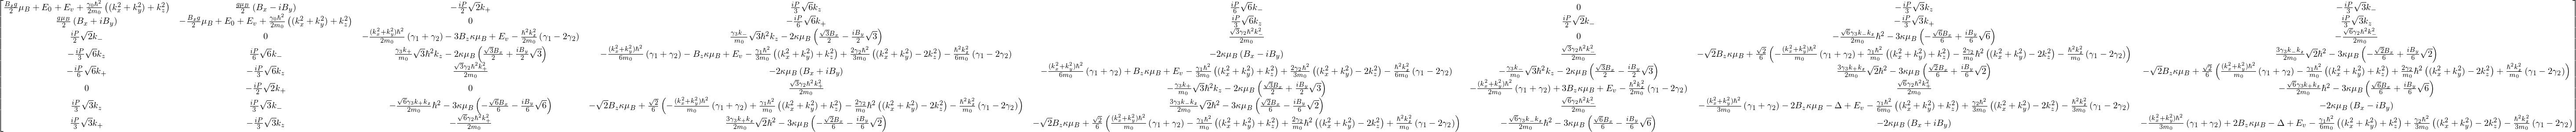

In [2]:
akm.H_polar

# Infinite wire with hard boundaries

In [9]:
## wire parameters                                                                                                                                                   
diameter = 800  # in Angstrom
Nd       = 401  # radial discretization steps
kz       = 0.   # momentum along wire
B        = 1e-6 # just for measuring g-factors
Fz_max   = 5/2 
Fz_list  = np.linspace(-Fz_max,Fz_max,2*Fz_max+1) # list of angular momenta sectors to solve
n = 8           # how many energies to keep in each sector 
material = 'InSb'
par = angstrom_par(B=[0,0,B],gamma_0=5,material=material)  # k.p parameters
par

{'gamma_1': 7.0319000398136993,
 mu_B: 5.7883818012e-05,
 'gamma_0': 5,
 'E_0': 0.237,
 'Delta': 0.81,
 'B_x': 0,
 'kappa': 0.56595001990684857,
 'P': 9.0250425806218111,
 'B_y': 0,
 'g': -5.0362923252131822,
 m_0: 5.685630060215049e-30,
 'gamma_3': 2.6659500199068482,
 hbar: 6.5821195139999995e-15,
 'B_z': 1e-06,
 'epsilon': 16.8,
 'gamma_2': 1.4659500199068489,
 'E_v': -0.237}

In [4]:
## solve wire
E_list = [] # energies
V_list = [] # states
S_list = [] # spin expectation values of s-orbital (for g-factor)
density_list = []
for fz in Fz_list:
    print(fz)
    E, V = solve_cylindrical(akm.H_dict,akm.J,diameter,Nd,fz,kz,B,par=par,nsparse=40,solverargs={'sigma':0})
    log = E > 0 # only take energies in conduction band starting at E=0
    E = E[log]
    V = V[:,log]
    E = E[:n]
    V = V[:,:n]

    assert np.isclose(E.imag,0).all()

    density = np.abs(V.T)**2
    for i in range(1,8):
        density[:,:Nd] += density[:,i*Nd:(i+1)*Nd]
    density = density[:,:Nd]
    
    S_list.append([
            2*(LA.norm(v[:Nd])/LA.norm(v)-0.5) for v in V.T
        ])

    E_list.append(E)
    V_list.append(V)
    density_list.append(density)

-2.5
-1.5
-0.5
0.5
1.5
2.5


<IPython.core.display.Math object>

<IPython.core.display.Latex object>

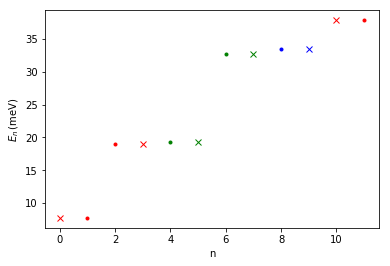

In [5]:
## show energy levels
cs1 = ['b','g','r','r','g','b']
cs2 = ['.','.','.','x','x','x']

ind1 = np.argsort(np.array(E_list).flatten().real)
ind2 = [(i//n,i%n) for i in ind1]

E = np.array([E_list[i][j] for i,j in ind2]).real
cs = [cs1[i]+cs2[i] for i,j in ind2]                                                                                                                                 
V = np.array([V_list[i][:,j] for i,j in ind2])
S = np.array([S_list[i][j] for i,j in ind2])
density = np.array([density_list[i][j] for i,j in ind2])

gfactors = np.sign(np.diff(S)[:12:2])*np.diff(E)[:12:2]/LA.norm(B)/5.788382e-5                                                                                                                 

display(Math('g = '+', '.join('{:0.2f}'.format(gi) for gi in gfactors)))
display(Latex('$\Delta E_1 = {:0.2f}\,$meV'.format((E_list[1][0]-E_list[2][1]).real*1e3)))

plt.figure()
for i,e in enumerate(E[:12]):
    plt.plot(i,1e3*e,cs[i])
plt.ylabel(r'$E_n\,(\mathrm{meV})$')
plt.xlabel(r'n')
plt.show()

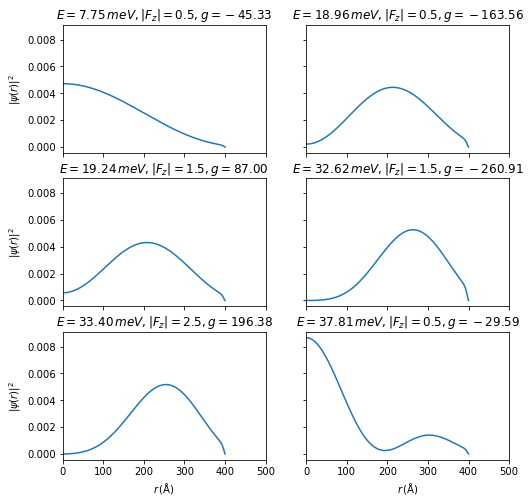

In [6]:
## Norm squared wave functions
rho = np.linspace(0,diameter/2,Nd)
fig, axes = plt.subplots(figsize=(8,8),nrows=3,ncols=2, sharey=True,sharex=True)
for i in range(0,12,2):                                                                                                                                      
    ax = axes[i//4,(i//2)%2]
    ax.set_title(r"$E = {0:0.2f}\,meV, |F_z| = {1:0.1f}, g = {2:0.2f}$".format(1e3*E[i],abs(Fz_list[ind2[i][0]]),gfactors[i//2]))
    ax.plot(rho,density[i],label='Fz = '+str(Fz_list[ind2[i][0]]))
    ax.set_xlim([0,500])
for ax in axes[-1,:]:
    ax.set_xlabel(r'$r\,(\mathrm{\AA})$')
for ax in axes[:,0]:
    ax.set_ylabel(r'$|\psi(r)|^2$')
plt.show()

## Diameter dependence:

In [7]:
diameter_list = 80*2**np.arange(7)
Nd       = 801
kz       = 0.
B        = 0.0
Fz_list  = [1/2,3/2,5/2]
n = 4

In [8]:
E_list = [[] for _ in diameter_list]
V_list = [[] for _ in diameter_list]
density_list = [[] for _ in diameter_list]
for nd, diameter in enumerate(diameter_list):
    print(diameter)
    for fz in Fz_list:
        print(fz)
        E, V = solve_cylindrical(akm.H_dict,akm.J,diameter,Nd,fz,kz,B,par=par,nsparse=40,solverargs={'sigma':0})
        log = E > 0
        E = E[log]
        V = V[:,log]
        E = E[:n]
        V = V[:,:n]

        assert np.isclose(E.imag,0).all()

        density = np.abs(V.T)**2
        for i in range(1,8):
            density[:,:Nd] += density[:,i*Nd:(i+1)*Nd]
        density = density[:,:Nd]

        E_list[nd].append(E)
        V_list[nd].append(V)
        density_list[nd].append(density)

E = np.array(E_list).real

80
0.5
1.5
2.5
160
0.5
1.5
2.5
320
0.5
1.5
2.5
640
0.5
1.5
2.5
1280
0.5
1.5
2.5
2560
0.5
1.5
2.5
5120
0.5
1.5
2.5
10240
0.5
1.5
2.5


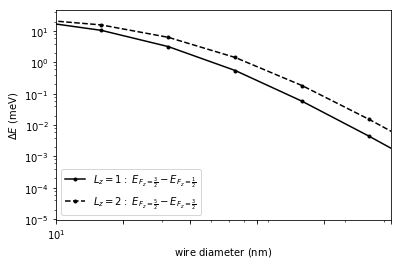

In [10]:
W = np.array(diameter_list)/10

plt.figure(figsize=(6,4))
plt.subplots_adjust(bottom=0.15)
plt.loglog(W,1e3*(E[:,1,0]-E[:,0,1]),'k.-',label=r"$L_z=1:\ E_{F_z=\frac{3}{2}}-E_{F_z=\frac{1}{2}}$")
plt.loglog(W,1e3*(E[:,2,0]-E[:,1,1]),'k.--',label=r"$L_z=2:\ E_{F_z=\frac{5}{2}}-E_{F_z=\frac{3}{2}}$")
plt.xlabel('$\mathrm{wire\ diameter}\ (\mathrm{nm})$')
plt.ylabel('$\Delta E\ (\mathrm{meV})$')
plt.legend(loc="lower left") 
plt.xlim([10, 320]) 
plt.xticks([10, 20, 40, 80, 160, 320]) 
plt.show()

In [11]:
diameter_list = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000]
Nd       = 401
kz       = 0.
B        = 0.005
Fz_max   = 5/2 
Fz_list  = np.linspace(-Fz_max,Fz_max,2*Fz_max+1)
n = 4

In [14]:
E_list = [[] for _ in diameter_list]
V_list = [[] for _ in diameter_list]
density_list = [[] for _ in diameter_list]

## wire parameters                                                                                                                                                                                                   
for nd, diameter in enumerate(diameter_list):
    print(diameter)                                                                                                                                                                                                  
    for fz in Fz_list:
        print(fz)
        par = angstrom_par(B=[0,0,B],gamma_0=5,material=material)
        E, V = solve_cylindrical(akm.H_dict,akm.J,diameter,Nd,fz,kz,B,par=par,nsparse=40,solverargs={'sigma':0})
        E-= 0
        log = E > 0
        E = E[log]
        V = V[:,log]
        E = E[:n]
        V = V[:,:n]

        assert np.isclose(E.imag,0).all()

        density = np.abs(V.T)**2
        for i in range(1,8):
            density[:,:Nd] += density[:,i*Nd:(i+1)*Nd]
        density = density[:,:Nd]

        E_list[nd].append(E)
        V_list[nd].append(V)
        density_list[nd].append(density)

E = np.array(E_list).real

gfactors = []
for E_i in E_list:
    dE = [E_i[2][0]-E_i[3][0],
          E_i[3][1]-E_i[2][1],
          E_i[1][0]-E_i[4][0],
          E_i[4][1]-E_i[1][1],
          E_i[0][0]-E_i[5][0],
          E_i[3][2]-E_i[2][2]]
    gfactors.append(-np.array(dE).real/LA.norm(B)/5.788382e-5)
gfactors = np.array(gfactors)

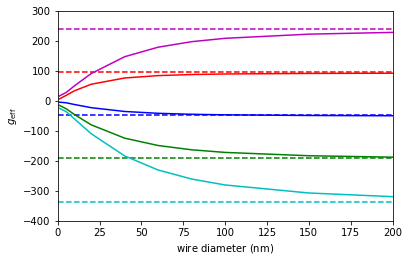

In [16]:
L_z     = [0,-1,+1,-2,+2]
c = ['b','g','r','c','m']
m_star  = 0.0139
g_star  = 48.08

plt.figure(figsize=(6,4))
plt.subplots_adjust(bottom=0.15)
for i in range(5):
    plt.plot(np.array(diameter_list)/10,gfactors[:,i], color=c[i])
    plt.axhline(-g_star+2*L_z[i]/m_star,linestyle='--',color=c[i])
plt.xlabel('$\mathrm{wire\ diameter}\ (\mathrm{nm})$')
plt.ylabel('$g_\mathrm{eff}$')
plt.ylim([-400,300])
plt.xlim([0, 200])
plt.show()

# Infinite wire with soft boundaries

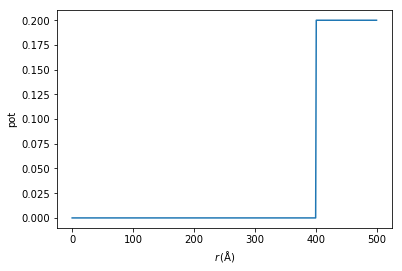

In [8]:
## wire parameters                                                                                                                                                   
diameter = 1000  # in Angstrom
Nd       = 501  # radial discretization steps
kz       = 0.   # momentum along wire
B        = 1e-6 # just for measuring g-factors
Fz_max   = 5/2 
Fz_list  = np.linspace(-Fz_max,Fz_max,2*Fz_max+1) # list of angular momenta sectors to solve
n = 8           # how many energies to keep in each sector 
par = angstrom_par(B=[0,0,B],gamma_0=5,material='InSb')  # k.p parameters
pot = lambda r: 0.2*(r>0.4*diameter) # soft potential
rho = np.linspace(0,diameter/2,Nd)
plt.figure()
plt.plot(rho,[pot(r) for r in rho])
plt.xlabel(r'$r\,(\mathrm{\AA})$')
plt.ylabel('pot')
plt.show()

In [9]:
## solve wire
E_list = [] # energies
V_list = [] # states
S_list = [] # spin expectation values of s-orbital (for g-factor)
density_list = []
for fz in Fz_list:
    print(fz)
    E, V = solve_cylindrical(akm.H_dict,akm.J,diameter,Nd,fz,kz,B,par=par,nsparse=40,solverargs={'sigma':0},potential=pot)
    log = E > 0 # only take energies in conduction band starting at E=0
    E = E[log]
    V = V[:,log]
    E = E[:n]
    V = V[:,:n]

    assert np.isclose(E.imag,0).all()

    density = np.abs(V.T)**2
    for i in range(1,8):
        density[:,:Nd] += density[:,i*Nd:(i+1)*Nd]
    density = density[:,:Nd]
    
    S_list.append([
            2*(LA.norm(v[:Nd])/LA.norm(v)-0.5) for v in V.T
        ])

    E_list.append(E)
    V_list.append(V)
    density_list.append(density)

-2.5
-1.5
-0.5
0.5
1.5
2.5


<IPython.core.display.Math object>

<IPython.core.display.Latex object>

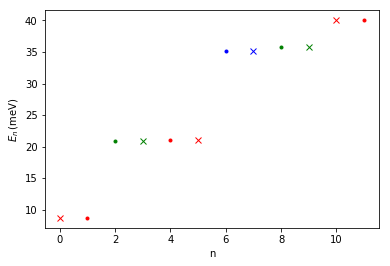

In [10]:
## show energy levels
cs1 = ['b','g','r','r','g','b']
cs2 = ['.','.','.','x','x','x']

ind1 = np.argsort(np.array(E_list).flatten().real)
ind2 = [(i//n,i%n) for i in ind1]

E = np.array([E_list[i][j] for i,j in ind2]).real
cs = [cs1[i]+cs2[i] for i,j in ind2]                                                                                                                                 
V = np.array([V_list[i][:,j] for i,j in ind2])
S = np.array([S_list[i][j] for i,j in ind2])
density = np.array([density_list[i][j] for i,j in ind2])

gfactors = np.sign(np.diff(S)[:12:2])*np.diff(E)[:12:2]/LA.norm(B)/5.788382e-5                                                                                                                 

display(Math('g = '+', '.join('{:0.2f}'.format(gi) for gi in gfactors)))
display(Latex('$\Delta E_1 = {:0.2f}\,$meV'.format((E_list[1][0]-E_list[2][1]).real*1e3)))

plt.figure()
for i,e in enumerate(E[:12]):
    plt.plot(i,1e3*e,cs[i])
plt.ylabel(r'$E_n\,(\mathrm{meV})$')
plt.xlabel(r'n')
plt.show()

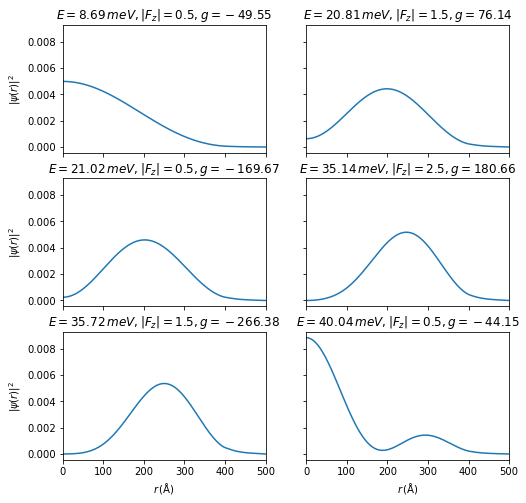

In [11]:
## Norm squared wave functions
rho = np.linspace(0,diameter/2,Nd)
fig, axes = plt.subplots(figsize=(8,8),nrows=3,ncols=2, sharey=True,sharex=True)
for i in range(0,12,2):                                                                                                                                      
    ax = axes[i//4,(i//2)%2]
    ax.set_title(r"$E = {0:0.2f}\,meV, |F_z| = {1:0.1f}, g = {2:0.2f}$".format(1e3*E[i],abs(Fz_list[ind2[i][0]]),gfactors[i//2]))
    ax.plot(rho,density[i],label='Fz = '+str(Fz_list[ind2[i][0]]))
    ax.set_xlim([0,500])
for ax in axes[-1,:]:
    ax.set_xlabel(r'$r\,(\mathrm{\AA})$')
for ax in axes[:,0]:
    ax.set_ylabel(r'$|\psi(r)|^2$')
plt.show()

## Diameter dependence:

In [17]:
diameter_list = 5/4*10*2**np.arange(5,10)
Nd       = 401
kz       = 0.
B        = 0.0
Fz_list  = [1/2,3/2,5/2]
n = 4
par = angstrom_par(B=[0,0,B],gamma_0=5,material=material)                                                                                                                                                            
pot = lambda r: 0.2*(r>0.4*diameter)

In [18]:
E_list = [[] for _ in diameter_list]
V_list = [[] for _ in diameter_list]
density_list = [[] for _ in diameter_list]

for nd, diameter in enumerate(diameter_list):
    print(diameter)
    for fz in Fz_list:
        print(fz)
        E, V = solve_cylindrical(akm.H_dict,akm.J,diameter,Nd,fz,kz,B,par=par,nsparse=40,solverargs={'sigma':0},potential=pot)
        log = E > 0
        E = E[log]
        V = V[:,log]
        E = E[:n]
        V = V[:,:n]

        density = np.abs(V.T)**2
        for i in range(1,8):
            density[:,:Nd] += density[:,i*Nd:(i+1)*Nd]
        density = density[:,:Nd]

        E_list[nd].append(E)
        V_list[nd].append(V)
        density_list[nd].append(density)

400.0
0.5
1.5
2.5
800.0
0.5
1.5
2.5
1600.0
0.5
1.5
2.5
3200.0
0.5
1.5
2.5
6400.0
0.5
1.5
2.5


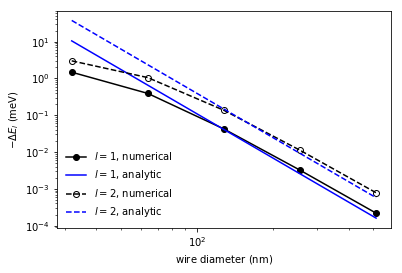

In [25]:
diameter = np.array(diameter_list)*4/5 # soft boundary of wire

def delta_E(l,p,diameter,par):
    W = np.array(diameter)/2
    dE = l*(( 4*par['P']**4*jn_zeros(l,p+1)[-1]**2 *
              par['Delta']*(par['Delta']+2*par['E_0']) *
              (2*par['Delta']+3*par['E_0']))/
            (9*W**4*par['E_0']**3*(par['Delta']+par['E_0'])**3))
    return dE

E = np.array(E_list).real
d1 = delta_E(1,0,diameter,par)
d2 = delta_E(2,0,diameter,par)

plt.figure()
plt.loglog(diameter/10,1e3*np.abs(E[:,1,0]-E[:,0,1]),'ko-',label=r"$l=1$, numerical")
plt.loglog(diameter/10,1e3*d1,'b-',label=r"$l=1$, analytic")
plt.loglog(diameter/10,1e3*np.abs(E[:,1,1]-E[:,2,0]),'ko--',label=r"$l=2$, numerical",mfc='none')
plt.loglog(diameter/10,1e3*d2,'b--',label=r"$l=2$, analytic")
plt.ylabel('$-\Delta E_l\ (\mathrm{meV})$')
plt.xlabel('$\mathrm{wire\ diameter}\ (\mathrm{nm})$')
plt.legend(mode='expand',ncol=1,frameon=False,loc="lower left")
plt.show()

# Finite wire - Cylindrical dot

In [12]:
## wire parameters                                                                                                                                                   
diameter = 400  # in Angstrom
length   = 400  # in Angstrom
Ndr      = 21   # radial discretization steps
Ndz      = 41   # axial discretization steps
B        = 1e-6 # just for measuring g-factors
Fz_max   = 5/2 
Fz_list  = np.linspace(-Fz_max,Fz_max,2*Fz_max+1) # list of angular momenta sectors to solve
n = 8           # how many energies to keep in each sector 
par = angstrom_par(B=[0,0,B],gamma_0=5,material='InSb')  # k.p parameters

In [13]:
E_list = []
V_list = []
S_list = []
density_list = []
for fz in Fz_list:
    print(fz)
    E, V = solve_cylindrical(akm.H_dict,akm.J,diameter,Ndr,fz,B=B,par=par,nsparse=80,solverargs={'sigma':0},Ndz=Ndz,length=length)
    log = E > 0
    E = E[log]
    V = V[:,log]
    E = E[:n]
    V = V[:,:n]
    
    assert np.isclose(E.imag,0).all()

    density = np.zeros((n,Ndz,Ndr))
    for i in range(8):
        for j in range(Ndz):
            density[:,j] += np.abs(V[i*Ndr*Ndz+j:(i+1)*Ndr*Ndz+j:Ndz].T)**2

    S = 0
    density = np.zeros((n,Ndz,Ndr))
    for i in range(8):
        for j in range(Ndz):
            density[:,j] += np.abs(V[i*Ndr*Ndz+j:(i+1)*Ndr*Ndz+j:Ndz].T)**2
            if i == 0:
                S += np.sum(np.abs(V[i*Ndr*Ndz+j:(i+1)*Ndr*Ndz+j:Ndz].T)**2,1)
            elif i == 1:
                S -= np.sum(np.abs(V[i*Ndr*Ndz+j:(i+1)*Ndr*Ndz+j:Ndz].T)**2,1)
            
    E_list.append(E)
    V_list.append(V)
    S_list.append(S)
    density_list.append(density)

-2.5
-1.5
-0.5
0.5
1.5
2.5


<IPython.core.display.Math object>

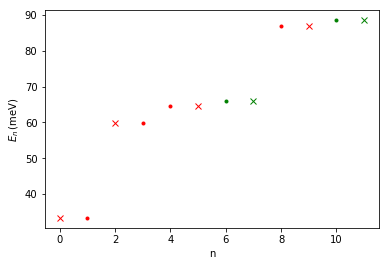

In [14]:
## show energy levels
cs1 = ['b','g','r','r','g','b']
cs2 = ['.','.','.','x','x','x']

ind1 = np.argsort(np.array(E_list).flatten().real)
ind2 = [(i//n,i%n) for i in ind1]

E = np.array([E_list[i][j] for i,j in ind2]).real
cs = [cs1[i]+cs2[i] for i,j in ind2]                                                                                                                                 
V = np.array([V_list[i][:,j] for i,j in ind2])
S = np.array([S_list[i][j] for i,j in ind2])
density = np.array([density_list[i][j] for i,j in ind2])

gfactors = np.sign(np.diff(S)[:12:2])*np.diff(E)[:12:2]/LA.norm(B)/5.788382e-5                                                                                                                 

display(Math('g = '+', '.join('{:0.2f}'.format(gi) for gi in gfactors)))
#display(Latex('$\Delta E_1 = {:0.2f}\,$meV'.format((E_list[1][0]-E_list[2][2]).real*1e3)))

plt.figure()
for i,e in enumerate(E[:12]):
    plt.plot(i,1e3*e,cs[i])
plt.ylabel(r'$E_n\,(\mathrm{meV})$')
plt.xlabel(r'n')
plt.show()

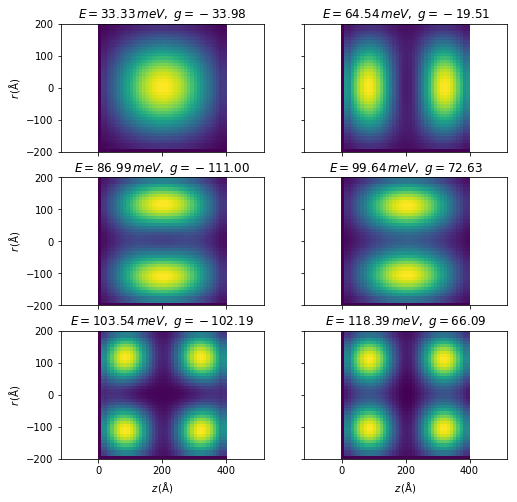

In [15]:
## Norm squared wave functions
r = np.linspace(0,diameter/2,Ndr)
r = np.concatenate((-r[::-1],r))
z = np.linspace(0,length    ,Ndz)
Z,R = np.meshgrid(z,r)
fig, axes = plt.subplots(figsize=(8,8),nrows=3,ncols=2, sharey=True,sharex=True)
for i in range(0,12,2):
    ax = axes[i//4,(i//2)%2]
    d = density[i].T
    d = np.vstack((d[::-1],d))
    ax.pcolormesh(Z,R,d,rasterized=True)
    ax.set_title('$ E = {0:.2f}\,meV,\ g = {1:.2f}$'.format(1e3*E[2*i],gfactors[i//2]))
    plt.axis('equal')
    ax.set_xlim([0,length])
    ax.set_ylim([-diameter/2,diameter/2])
for ax in axes[-1,:]:
    ax.set_xlabel(r'$z\,(\mathrm{\AA})$')
for ax in axes[:,0]:
    ax.set_ylabel(r'$r\,(\mathrm{\AA})$')    
plt.show()